# **Статистический анализ данных**

Вы аналитик популярного сервиса аренды самокатов. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 

**Описание данных**
В основных данных есть информация о пользователях, их поездках и подписках.
1. **Пользователи — users_go.csv**
- user_id	уникальный идентификатор пользователя
- name	имя пользователя
- age	возраст
- city	город
- subscription_type	тип подписки (free, ultra)
2. **Поездки — rides_go.csv**
- user_id	уникальный идентификатор пользователя
- distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date	дата совершения поездки
3. **Подписки — subscriptions_go.csv**
- subscription_type	тип подписки
- minute_price	стоимость одной минуты поездки по данной подписке
- start_ride_price	стоимость начала поездки
- subscription_fee	стоимость ежемесячного платежа

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, norm

### Загрузка данных

In [2]:
df_users = pd.read_csv('/datasets/users_go.csv')
df_rides = pd.read_csv('/datasets/rides_go.csv')
df_subs = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
df_users.info()
df_users.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
682,683,Лев,27,Сочи,ultra
222,223,Игорь,25,Тюмень,ultra
860,861,Мария,27,Краснодар,free
1187,1188,Захар,22,Омск,free
1353,1354,Петр,26,Екатеринбург,free
572,573,Петр,23,Краснодар,ultra
855,856,Валерия,36,Омск,free
174,175,Демид,18,Тюмень,ultra
1279,1280,София,24,Сочи,free
1513,1514,Ева,25,Тюмень,free


In [4]:
df_rides.info()
df_rides.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
6213,667,1208.565202,15.816522,2021-05-29
1110,119,2450.743965,12.446098,2021-04-25
17341,1485,2457.371160,20.143428,2021-02-08
906,96,4272.475360,21.079325,2021-12-19
16762,1440,2791.761971,12.982347,2021-06-01
1825,197,2776.809719,13.768873,2021-09-06
5660,604,4251.789334,26.221954,2021-01-12
73,7,1609.907996,13.330844,2021-04-09
11736,1083,2748.666553,17.497333,2021-01-10
3894,419,2924.150529,18.310376,2021-04-30


In [5]:
df_subs.info()
df_subs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Предварительно данные выглядят хорошо, пропусков не видно. Очевидная проблема - тип данных в столбце **date** таблицы df_rides должен быть datetime64[ns]. Касательно дублей будем смотреть в разделе предобработки.

### Предобработка данных

In [33]:
print(df_users.describe(),'\n')
print(df_rides.describe(),'\n')
print(df_subs.describe())

           user_id          age
count  1534.000000  1534.000000
mean    767.500000    24.903520
std     442.971971     4.572367
min       1.000000    12.000000
25%     384.250000    22.000000
50%     767.500000    25.000000
75%    1150.750000    28.000000
max    1534.000000    43.000000 

            user_id      distance      duration         month
count  18068.000000  18068.000000  18068.000000  18068.000000
mean     842.869936   3070.659976     17.805011      6.486772
std      434.734317   1116.831209      6.091051      3.437410
min        1.000000      0.855683      0.500000      1.000000
25%      487.000000   2543.226360     13.597563      4.000000
50%      889.000000   3133.609994     17.678395      6.000000
75%     1213.250000   3776.222735     21.724800      9.000000
max     1534.000000   7211.007745     40.823963     12.000000 

       minute_price  start_ride_price  subscription_fee
count      2.000000          2.000000          2.000000
mean       7.000000         25.000000 

На первый взгляд данные выглядят хорошо, средние соответствуют медиане. Оставим их как есть, пропуски отсутствуют, но проверим на дубликаты.

In [7]:
print(df_users.duplicated().sum())
print(df_rides.duplicated().sum())
print(df_subs.duplicated().sum())

31
0
0


In [8]:
df_users.drop_duplicates(inplace=True)
df_users.duplicated().sum()

0

Дубликаты обработали и удалили

In [9]:
display(df_users.value_counts())
display(df_rides.value_counts())
display(df_subs.value_counts())

user_id  name       age  city            subscription_type
1        Кира       22   Тюмень          ultra                1
1020     Камилла    32   Москва          free                 1
1029     Игорь      21   Краснодар       free                 1
1028     Вадим      17   Сочи            free                 1
1027     Мария      21   Сочи            free                 1
                                                             ..
510      Роман      24   Ростов-на-Дону  ultra                1
509      Ян         29   Москва          ultra                1
508      Станислав  15   Тюмень          ultra                1
507      Эвелина    27   Пятигорск       ultra                1
1534     Альберт    25   Краснодар       free                 1
Length: 1534, dtype: int64

user_id  distance     duration   date      
1        748.690645   15.041884  2021-11-22    1
1105     3232.037291  19.120140  2021-02-24    1
         4661.122393  21.159450  2021-03-25    1
         4468.509613  12.937019  2021-11-28    1
         4057.692285  21.695055  2021-06-05    1
                                              ..
645      4040.109793  17.100274  2021-11-26    1
646      2635.251399  11.081349  2021-09-06    1
         2853.140708  23.699278  2021-01-28    1
         3442.376310  22.753041  2021-03-17    1
1534     4928.173852  22.560373  2021-09-13    1
Length: 18068, dtype: int64

subscription_type  minute_price  start_ride_price  subscription_fee
free               8             50                0                   1
ultra              6             0                 199                 1
dtype: int64

Данные выглядят корректно.

In [10]:
df_rides['date'] = pd.to_datetime(df_rides['date'], format = '%Y-%m-%d')
df_rides.info()
df_rides['date'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


2021-12-22    72
2021-01-12    70
2021-12-27    69
2021-08-20    67
2021-06-09    67
              ..
2021-11-07    35
2021-07-30    35
2021-12-15    34
2021-02-02    34
2021-07-03    31
Name: date, Length: 364, dtype: int64

Привели столбец даты к нормальному формату pandas (также можно было применить к столбцу .astype('datetime64[ns]').

In [11]:
df_rides['month'] = df_rides['date'].dt.month
df_rides['month'].value_counts()

1     1585
5     1560
6     1553
3     1544
7     1529
12    1527
8     1518
9     1517
4     1506
10    1475
11    1418
2     1336
Name: month, dtype: int64

Добавили новый столбец в соответствии с заданием.

**Вывод: таким образом, мы успешно проверили данные на дубликаты и пропуски, привели тип данных столбца date к правильному, добавили новую колонку и номерами месяцев.**

### Исследовательский анализ данных

#### Частота встречаемости городов

In [12]:
def count_plot(row):
    return df_users.value_counts(row,ascending=False).plot(kind='bar', color='green', ec='black', grid=True, figsize=(9,6))

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

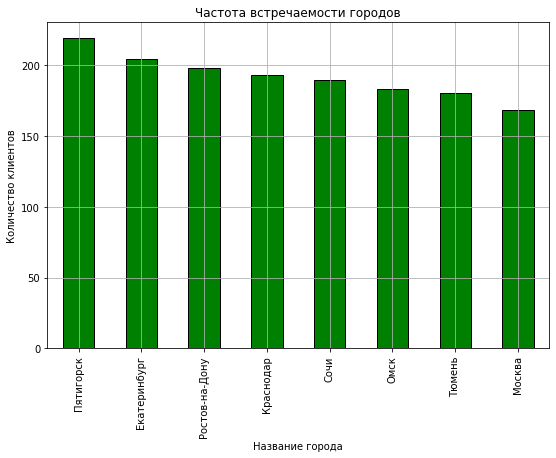

In [13]:
display(df_users['city'].value_counts())
count_plot('city')
plt.title('Частота встречаемости городов')
plt.xlabel('Название города')
plt.ylabel('Количество клиентов')
plt.show()

Как видим: чаще всего встречается Пятигорск, реже всего москва, но разница между частотами не велика.

#### Соотношение пользователей с подпиской и без подписки

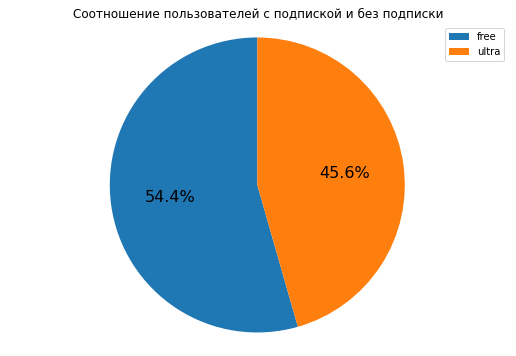

In [14]:
df_users['subscription_type'].value_counts(ascending=False).plot.pie(labels=None, autopct='%1.1f%%', 
                                                                     startangle=90,legend=True, figsize=(9,6), fontsize=16)
plt.axis('equal')
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.ylabel('')
plt.show()

Итак, из общего количества юзеров пользователей без подписки больше пользователей с подпиской на 8,8%.

#### Возраст пользователей

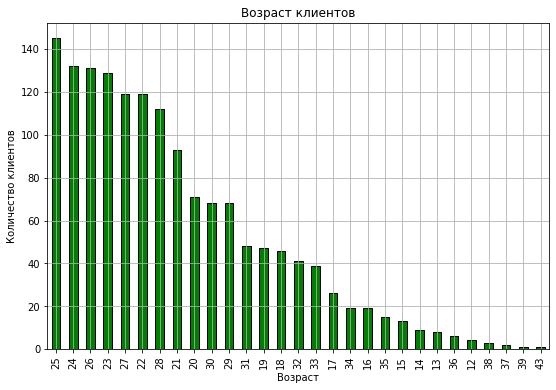

Средний возраст составляет: 24.9


In [15]:
count_plot('age')
plt.title('Возраст клиентов')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.show()
print('Средний возраст составляет:', df_users['age'].mean().round(2))

Возраст распределяется нормально, средний возраст пользователей 24,9 лет

#### Расстояние, которое пользователь преодолел за одну поездку

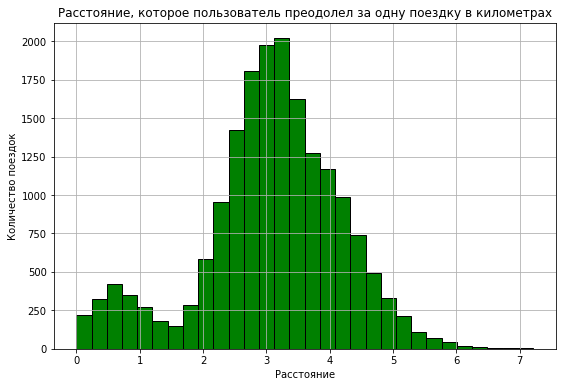

Среднее расстояние, которое пользователь проезжает за 1 поездку составляет 3.07 км


In [16]:
biba = df_rides['distance']/1000
biba.plot(
    title='Расстояние, которое пользователь преодолел за одну поездку в километрах', 
    kind='hist', bins=30, color='green', ec='black', grid=True, figsize=(9,6)
)
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()
print(f'Среднее расстояние, которое пользователь проезжает за 1 поездку составляет {biba.mean().round(2)} км')

Интересный изгиб левого хвоста распределения. Согласно полученным наблюдениям, можно сказать, что есть некие выбросы на расстоянии от 0 до 1,5 км. Но ситуация такая вполне реальна. Чаще всего пользователи путешествуют на расстояние 3 км.

#### Продолжительность поездок

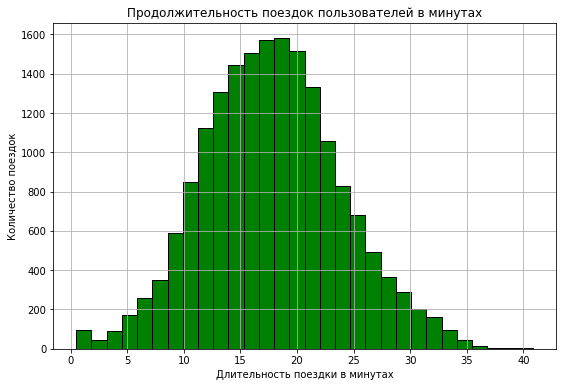

Среднее время одной поездки пользователя 17.8 минут


In [17]:
boba = df_rides['duration']
boba.plot(
    title = 'Продолжительность поездок пользователей в минутах',
    kind='hist', bins=30, color='green', ec='black', grid=True, figsize=(9,6)
)
plt.xlabel('Длительность поездки в минутах')
plt.ylabel('Количество поездок')
plt.show()
print(f'Среднее время одной поездки пользователя {boba.mean().round(1)} минут')

Получается, что чаще всего пользователи проводят в пути в среднем почти 18 минут. Снова видим небольшой выброс в районе 0, как и в ситуации с расстоянием поездки. Распределение данных нормальное.

**Вывод по разделу:
можем сложить портрет нашего "стандартного" пользователя - возраст 25 лет, продолжительность поездки около 17-18 минут, дальность 3 км. Касательно подписки и города проживания сложнее, поскольку разброс в данных слишком невелик.**

### Объединение данных

#### Объединим таблицы

In [18]:
big_df = pd.merge(df_users, df_rides, left_on='user_id', right_on='user_id')
big_df.head(10)
big_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 1.4+ MB


In [19]:
great_df = pd.merge(big_df, df_subs, left_on='subscription_type', right_on='subscription_type')
great_df.head(10)
great_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Сначала аккуратно объединили df_users с df_rides, затем полученную таблицу уже объединили с df_subs

#### Создадим ещё два датафрейма из полученной таблицы

In [20]:
subs = great_df[great_df['subscription_type'] == 'ultra']
unsubs = great_df[great_df['subscription_type'] == 'free']
subs.info()
print('\n')
unsubs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int64         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


<class 'pandas.core.frame.DataFrame'>


Разделили фрэйм на пользователей с подпиской и без.

#### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий

In [21]:
a = subs.pivot_table(index='user_id', values=('distance', 'duration'), aggfunc=('mean'))
a.columns = ['subs_distance','subs_duration']
a['subs_distance'] = (a['subs_distance']/1000).round(2)
a['subs_duration'] = a['subs_duration'].round(2)
b= unsubs.pivot_table(index='user_id', values=('distance', 'duration'), aggfunc=('mean'))
b.columns = ['unsubs_distance','unsubs_duration']
b['unsubs_distance'] = (b['unsubs_distance']/1000).round(2)
b['unsubs_duration'] = b['unsubs_duration'].round(2)
display(a.head(10))
display(b.head(10))

,subs_distance,subs_duration
user_id,,
1,2.84,17.05
2,3.09,17.97
3,3.08,19.43
4,3.20,20.61
5,3.23,15.82
6,3.41,20.33
7,3.04,16.15
8,3.15,18.14
9,2.97,16.22


,unsubs_distance,unsubs_duration
user_id,,
700,2.90,15.18
701,3.11,14.49
702,3.21,17.85
703,2.48,15.46
704,3.15,16.66
705,3.33,17.49
706,3.13,17.83
707,2.76,18.25
708,3.15,18.25


**Делаем 2 сводные таблицы для исследуемых показателей расстояния и времени поездки.**

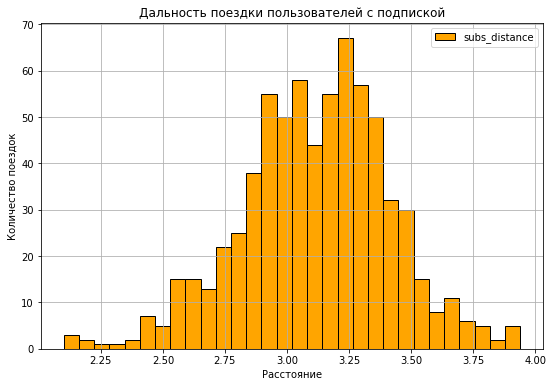

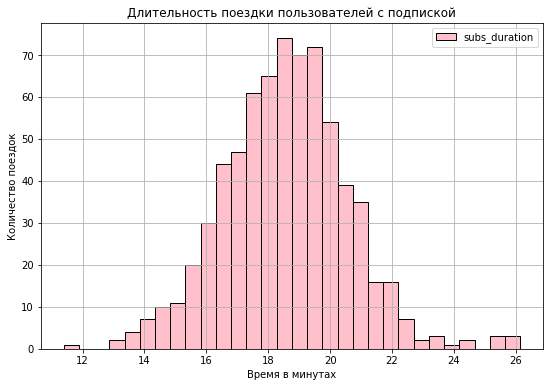

Количество пользователей с подпиской 699.
Среднее дальность одной поездки пользователя с подпиской 3.1 км.
Средняя длительность одной поездки пользователя с подпиской 18.6 мин.


In [22]:
a.plot(title='Дальность поездки пользователей с подпиской', y='subs_distance', 
       kind='hist', bins=30, grid=True, color='orange', ec='black',figsize=(9,6))
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
a.plot(title='Длительность поездки пользователей с подпиской', y='subs_duration', 
       kind='hist', bins=30, grid=True, color='pink', ec='black',figsize=(9,6))
plt.xlabel('Время в минутах')
plt.ylabel('Количество поездок')
plt.show()
print(f'Количество пользователей с подпиской {len(a["subs_distance"])}.')
print(f'Среднее дальность одной поездки пользователя с подпиской {a["subs_distance"].mean().round(1)} км.')
print(f'Средняя длительность одной поездки пользователя с подпиской {a["subs_duration"].mean().round(1)} мин.')

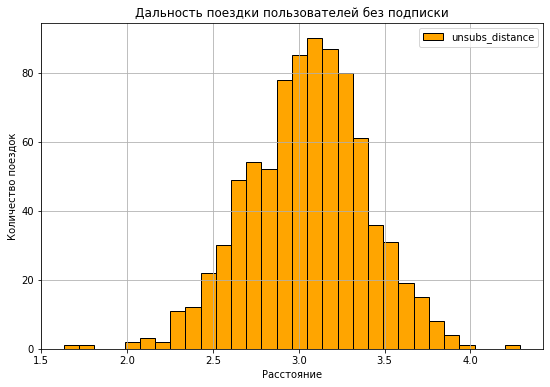

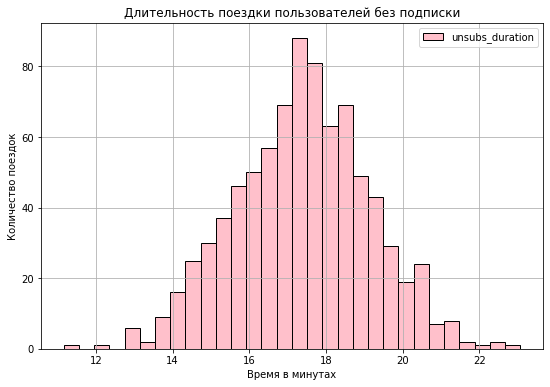

Количество пользователей без подписки 835.
Среднее дальность одной поездки пользователя без подписки 3.0 км.
Средняя длительность одной поездки пользователя без подписки 17.4 мин.


In [23]:
b.plot(title='Дальность поездки пользователей без подписки', y='unsubs_distance', 
       kind='hist', bins=30, grid=True, color='orange', ec='black',figsize=(9,6))
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
b.plot(title='Длительность поездки пользователей без подписки', y='unsubs_duration', 
       kind='hist', bins=30, grid=True, color='pink', ec='black',figsize=(9,6))
plt.xlabel('Время в минутах')
plt.ylabel('Количество поездок')
plt.show()
print(f'Количество пользователей без подписки {len(b["unsubs_distance"])}.')
print(f'Среднее дальность одной поездки пользователя без подписки {b["unsubs_distance"].mean().round(1)} км.')
print(f'Средняя длительность одной поездки пользователя без подписки {b["unsubs_duration"].mean().round(1)} мин.')

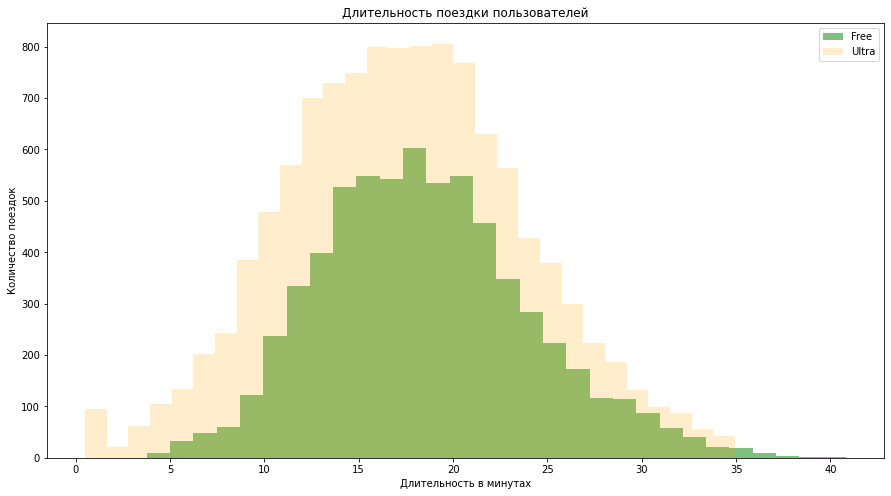

In [24]:
plt.subplots(figsize=(15, 8))
plt.hist(subs['duration'], 30, alpha=0.5, label='Free', color='green')
plt.hist(unsubs['duration'], 30, alpha=0.2, label='Ultra', color='orange')
plt.title('Длительность поездки пользователей')
plt.xlabel('Длительность в минутах')
plt.ylabel('Количество поездок')
plt.legend()
plt.show()


Видим, что пользователи с подпиской проводят больше времени в поездке, подтверждаем, что больше всего отмен поездок или быстрых поездок тоже у подписчиков.

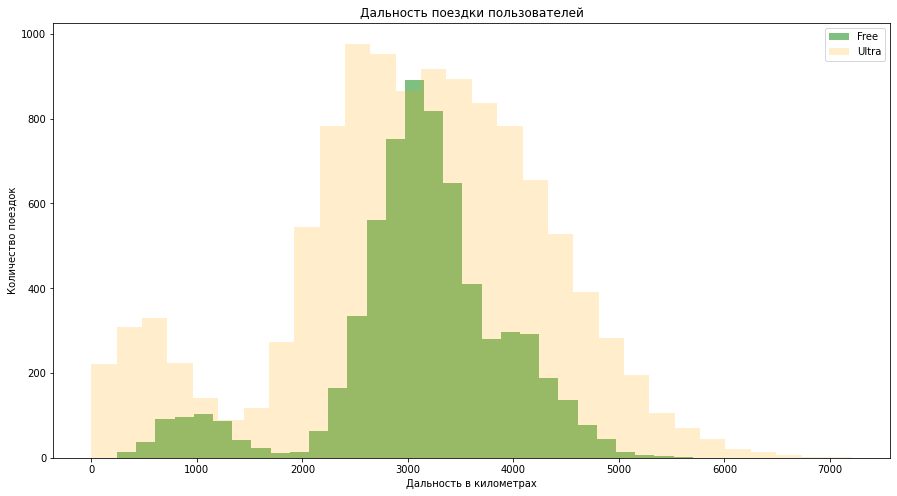

In [25]:
plt.subplots(figsize=(15, 8))
plt.hist(subs['distance'], 30, alpha=0.5, label='Free', color='green')
plt.hist(unsubs['distance'], 30, alpha=0.2, label='Ultra', color='orange')
plt.title('Дальность поездки пользователей')
plt.xlabel('Дальность в километрах')
plt.ylabel('Количество поездок')
plt.legend()
plt.show()


По дальности поездок ситуация почти одинаковая, а на короткие дистанции снова больше всего у подписчиков. 
*P.S. Я не стал все равно обрабатывать эти аномалии, поскольку их не много и такая ситуация вероятна. Позволяет проанализировать у какой категории аномалии доминируют.*

**Вывод: Объединили таблицы и создали новые, необходимые для дальнейшей оценки показателей. Из графиков таблиц пользователей с подпиской и без подписки мы видим, что пользователи с подпиской проезжают в среднем дальше (3.1 > 3км.) и дольше (18.6 > 17.4 мин.), чем пользователи без нее.**

### Подсчёт выручки

#### и  5.2 Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [26]:
networth_great_df = great_df.copy()
networth_great_df['duration'] = np.ceil(networth_great_df['duration'])
networth_great_df['count_rides'] = networth_great_df['user_id']

#посчитали стоимость поездки для каждого пользователя
networth_great_df['net_value'] = networth_great_df[
    'start_ride_price'] + networth_great_df['minute_price'] * networth_great_df[
    'duration']

networth_great_df = networth_great_df.groupby(
    ['user_id','month','name','subscription_type', 'subscription_fee'],as_index=False
    ).agg({'distance':'sum', 'duration':'sum', 'count_rides':'count', 'net_value':'sum'}
     ).sort_values(by='month', ascending=True)

#теперь посчитали помесячную с учетом подписки
networth_great_df['net_worth'] = networth_great_df['net_value'] + networth_great_df['subscription_fee'] 

display(networth_great_df.head(10))

,user_id,month,name,subscription_type,subscription_fee,distance,duration,count_rides,net_value,net_worth
0,1,1,Кира,ultra,199,7027.511294,42.0,2,252.0,451.0
4450,686,1,Айдар,ultra,199,9891.825690,53.0,3,318.0,517.0
4444,685,1,Даниил,ultra,199,4837.670420,47.0,2,282.0,481.0
4429,682,1,Евгения,ultra,199,2929.820795,25.0,1,150.0,349.0
4414,680,1,Тимофей,ultra,199,3316.977004,18.0,1,108.0,307.0
4409,679,1,Дамир,ultra,199,6407.866143,38.0,2,228.0,427.0
4388,675,1,Макар,ultra,199,3907.983157,21.0,1,126.0,325.0
4381,674,1,Эмиль,ultra,199,2952.626152,11.0,1,66.0,265.0
4375,673,1,Иван,ultra,199,3371.773487,24.0,1,144.0,343.0
4358,671,1,Софья,ultra,199,3649.397977,12.0,1,72.0,271.0


**Заключение по разделу: Я решил объединить сразу 2 задания: 
В этот же датафрейм добавил столбец с помесячной выручкой (net_worth), которую принёс каждый пользователь. Для этого обратился к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа.**

*P.S. Возможно, решение получилось громоздкое, но результат довольно аккуратный, что мне и нравится.*

### Проверка гипотез

#### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Формулируем гипотезы:

- Нулевая гипотеза (H0): Среднее время поездок пользователей с подпиской не больше, чем у пользователей без подписки.
- Альтернативная гипотеза (H1): Среднее время поездок пользователей с подпиской больше, чем у пользователей без подписки.

В данном случае мы сравниваем среднюю продолжительность поездок двух независимых групп: пользователей с подпиской и без подписки.

In [27]:
alpha = 0.05

t_stat, p_value = st.ttest_ind(subs['duration'], unsubs['duration'], alternative='greater', equal_var=True)

print(f't-statistic: {t_stat}, one-sided p_value: {p_value}')

if p_value < alpha:
    print('Отвергаем нулевую гипотезу. Получается пользователи с подпиской тратят больше времени на поездки.')
else:
    print('Не можем отвергнуть нулевую гипотезу: нет доказательств, что пользователи с подпиской тратят больше времени.')

t-statistic: 12.241203729044017, one-sided p_value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу. Получается пользователи с подпиской тратят больше времени на поездки.


Согласно проведенному тесту: пользователи с подпиской тратят больше времени на поездку, чем пользователи без нее. Пользователи с подпиской могут быть "выгоднее" для компании.

#### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим гипотезу и сделаем выводы.

Гипотезы:
- Нулевая гипотеза (H0): Среднее расстояние, которое проезжают пользователи с подпиской, равно или меньше 3130 метров.
- Альтернативная гипотеза (H1): Среднее расстояние, которое проезжают пользователи с подпиской, больше 3130 метров.

Выборка одна, проводим тест one-sample t-test

In [28]:
alpha = 0.05
value = 3130

t_stat, p_value = st.ttest_1samp(subs['distance'], value, alternative='greater')
    
print(f't-statistic: {t_stat}, one-sided p-value: {p_value}')

if p_value < alpha:
     print('Отвергаем нулевую гипотезу. Получается среднее расстояние, которое проезжают пользователи, больше 3130 метров')
else:
    print('Нулевую гипотезу нельзя отвергнуть: Среднее расстояние, которое проезжают пользователи, равно или меньше 3130 метров.')

t-statistic: -1.402123166869486, one-sided p-value: 0.9195368847849785
Нулевую гипотезу нельзя отвергнуть: Среднее расстояние, которое проезжают пользователи, равно или меньше 3130 метров.


Таким образом, получаем, что среднее расстояние, которое проезжают пользователи, равно или меньше 3130 метров, что подтверждает нулевую гипотезу. Получается, что износ самоката соответствует норме.

#### Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Гипотезы:
- Нулевая гипотеза (H0): Средняя помесячная выручка от пользователей с подпиской не больше, чем от пользователей без подписки.
- Альтернативная гипотеза (H1): Средняя помесячная выручка от пользователей с подпиской больше, чем от пользователей без подписки.

Выполним t-тест для независимых выборок.

In [29]:
networth_great_subs = networth_great_df[networth_great_df['subscription_type'] == 'ultra']
networth_great_unsubs = networth_great_df[networth_great_df['subscription_type'] == 'free']

alpha = 0.05

t_stat, p_value = st.ttest_ind(networth_great_subs['net_worth'], networth_great_unsubs['net_worth'], alternative= 'greater', equal_var=True)


print(f't-statistic: {t_stat}, one-sided p-value: {p_value}')

if p_value < alpha:
     print('Отвергаем нулевую гипотезу: Средняя помесячная выручка от пользователей с подпиской больше, чем от пользователей без подписки.')
else:
    print('Нулевую гипотезу нельзя отвергнуть: Средняя помесячная выручка от пользователей с подпиской не больше, чем от пользователей без подписки.')

t-statistic: 11.64246602360774, one-sided p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу: Средняя помесячная выручка от пользователей с подпиской больше, чем от пользователей без подписки.


Отвергаем нулевую гипотезу. Получается, что средняя помесячная выручка от пользователей с подпиской больше, чем от пользователей без подписки.

#### Представьте такую ситуацию: техническая команда сервиса обновила серверы, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Формулировка гипотез:
- Нулевая гипотеза (H0): Среднее количество обращений не изменилось или стало больше после обновления серверов.
- Альтернативная гипотеза (H1): Среднее количество обращений снизилось после обновления серверов.

Почему парный t-тест (ttest_rel):
- Зависимые выборки: данные представляют собой парные наблюдения для одного и того же пользователя до и после обновления.
- Мы проверяем гипотезу об уменьшении обращений, что указывает на необходимость проведения одностороннего теста.

### Распределения

#### Отделу маркетинга поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Минимальное количество промокодов: 1161


/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


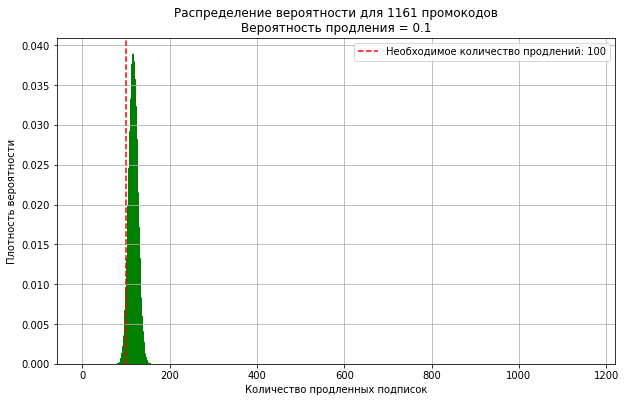

In [30]:
p = 0.1 
k = 100  
alpha = 0.05

def find_min_promocodes(p, k, alpha):
    n = k 
    while True:
        
        #if n <= 0 or p <= 0 or p > 1:
           #raise ValueError("Некорректные значения параметров: n или p") (костыль, когда вылезает ошибка при делении на ноль)
            
        # Вероятность того, что продлений будет меньше, чем k
        prob = binom.cdf(k - 1, n, p)
        if prob <= alpha:
            return n
        n += 1

#Находим минимальное количество промокодов
min_promocodes = find_min_promocodes(p, k, alpha)
print(f'Минимальное количество промокодов: {min_promocodes}')

# Построение графика распределения вероятностей
x = np.arange(0, min_promocodes + 1)
pmf = binom.pmf(x, min_promocodes, p)

plt.figure(figsize=(10, 6))
plt.bar(x, pmf, color='blue', ec='green')
plt.axvline(k, color='red', linestyle='--', label=f'Необходимое количество продлений: {k}')
plt.title(f'Распределение вероятности для {min_promocodes} промокодов\nВероятность продления = {p}')
plt.xlabel('Количество продленных подписок')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid(True)
plt.show()

Согласно оценке полученного распределения мы видим, что для достижения цели с вероятностью не менее 95%, нужно разослать как минимум 1161 промокод.

#### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [31]:
from math import sqrt

Вероятность того, что откроют не более 399,5 тыс. уведомлений: 0.1537


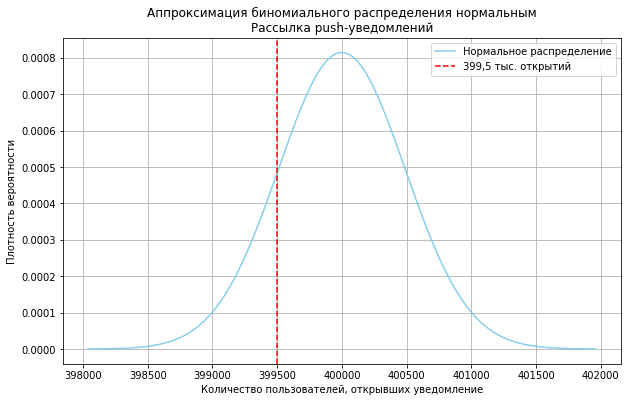

In [32]:
n = 1000000  
p = 0.4 
k = 399500 

mu = n * p  # среднее
sigma = np.sqrt(n * p * (1 - p)) 

prob = norm.cdf(k, mu, sigma)
print(f'Вероятность того, что откроют не более 399,5 тыс. уведомлений: {prob:.4f}')

# Построение графика нормального распределения
x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 1000)
y = norm.pdf(x, mu, sigma)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Нормальное распределение', color='skyblue')
plt.axvline(k, color='red', linestyle='--', label=f'399,5 тыс. открытий')
plt.title('Аппроксимация биномиального распределения нормальным\nРассылка push-уведомлений')
plt.xlabel('Количество пользователей, открывших уведомление')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid(True)
plt.show()

Согласно исследованию, вероятность того, что уведомление откроют не более 399,5 тысяч пользователей, составляет примерно 15,37%.

**Вывод по разделу: Я-таки разобрался в построении распределений и аппроксимации биноминального нормальным. Узнал необходимые результаты и построилграфики.**

### Итоги проектной работы

**Общий вывод:**

1. Успешно импортировал таблицу, определил проблемные места, оценил общую ситуацию с данными, импортировал рабочие библиотеки.
2. Провел предобработку данных, проверил на дубликаты и пропуски, поработал над типом данных.
3. Провел исследовательских анализ параметров и их распределения. Складывается портрет нашего "стандартного" пользователя - возраст 25 лет, продолжительность поездки около 17-18 минут, дальность 3 км.
4. Объединил таблицы и создал новые, необходимые для дальнейшей оценки показателей. Из первоначального сравнения получил, что с подпиской пользователи проезжали дальше и дольше.
5. Создал еще дата фрэйм, где получил столбец выручки каждого пользователя по месяцам.
6. Выдвинул гипотезы и проверил их. В результате: 1) Пользователи с подпиской тратят больше времени на поездку, чем пользователи без нее.
2) Среднее расстояние, которое проезжают пользователи, равно или меньше 3130 метров, что не превышает норму износа самоката.
3) Средняя помесячная выручка от пользователей с подпиской больше, чем от пользователей без подписки.
Согласно тестам распределения, при нынешних тарифных планах, можно сказать, что пользователи с подпиской принесут больше выручки. Я бы предложил пересмотреть тарифный план для бесплатных тарифов, чтобы больше людей склонялись к оформлению подписки.
7. Касательно заданий по распределениям я определил, что: - Для достижения цели с вероятностью не менее 95%, нужно разослать как минимум 1161 промокод. - Вероятность того, что уведомление откроют не более 399,5 тысяч пользователей, составляет примерно 15,37%.